# Deep Deterministic Policy Gradients (DDPG)

Homework project for DRL Continuous Action.

### 1. Import the Necessary Packages

In [1]:
import gym
import numpy as np
import random
import torch
import time # for perf count

from collections import deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

/home/anurag/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448272031/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


### 2. Instantiate the Environment and Agent

#### 2.1 Start the Environment

Before running the code cell below, change the file_name parameter to match the location of the Unity environment that you downloaded.

- Mac: "unity_env_single_agent/Reacher.app"
- Windows (x86): "unity_env_single_agent/Reacher_Windows_x86/Reacher.exe"
- Windows (x86_64): "unity_env_single_agent/Reacher_Windows_x86_64/Reacher.exe"
- Linux (x86): "unity_env_single_agent/Reacher.x86"
- Linux (x86_64): "unity_env_single_agent/Reacher.x86_64"
- Linux (x86, headless): "unity_env_single_agent/Reacher_Linux_NoVis/Reacher.x86"
- Linux (x86_64, headless): "unity_env_single_agent/Reacher_Linux_NoVis/Reacher.x86_64"

For instance, if you are using a Mac, then you downloaded Reacher.app. If this file is in the same folder as the notebook, then the line below should appear as follows:

env = UnityEnvironment(file_name="Reacher.app")

In [2]:
env = UnityEnvironment(file_name='unity_env_single_agent/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#### 2.2 Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector must be a number between -1 and 1.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train the Agent with DDPG

#### 3.1 Instantiate Agent with DDPG

In [5]:
from ddpg_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, random_seed=12)

Few utilitity functions:

In [6]:
def get_SARs(env_info):
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    return (next_state, reward, done)

Episode 100	Average Score: 6.60 	Time/Episode: 7.82Episode: 7.82
Episode 200	Average Score: 29.59 	Time/Episode: 8.30Episode: 8.308
Episode 204	Average Score: 30.02	Score: 28.53 	Time/Episode: 8.29
Environment solved in 104 episodes!	Average Score: 30.02


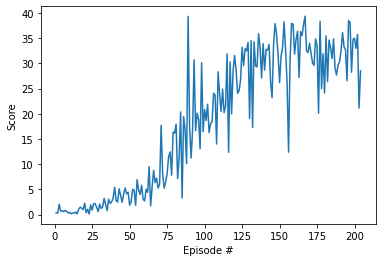

In [7]:
def ddpg(n_episodes=2000, max_t=10000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        start_time = time.perf_counter()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = get_SARs(env_info)
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        end_time = time.perf_counter()
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f} \tTime/Episode: {:.2f}'.format(i_episode, np.mean(scores_deque), score, (end_time - start_time)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tTime/Episode: {:.2f}'.format(i_episode, np.mean(scores_deque), (end_time - start_time)))
            
        if np.mean(scores_deque) >= 30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores

scores = ddpg(400)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent

In [8]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    state = env_info.vector_observations[0]                # get the current state (for each agent)
    score = np.zeros(num_agents)                           # initialize the score (for each agent)
    while True:
        action = agent.act(state)                          # select an action (for each agent)
        action = np.clip(action, -1, 1)                    # all actions between -1 and 1
        env_info = env.step(action)[brain_name]            # send all actions to tne environment
        next_state = env_info.vector_observations[0]       # get next state (for each agent)
        reward = env_info.rewards[0]                       # get reward (for each agent)
        done = env_info.local_done[0]                      # see if episode finished
        score += env_info.rewards[0]                       # update the score (for each agent)
        state = next_state                                 # roll over states to next time step
        if done:                                           # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(score))

Total score (averaged over agents) this episode: [25.66999943]
Total score (averaged over agents) this episode: [26.44999941]
Total score (averaged over agents) this episode: [36.52999918]


### 5. Cleanup

When finished, you can close the environment.

In [9]:
env.close()